# Protein-Protein Interactions in NetworkX

We will be using three important open source softwares:

    1) The Python programming language: www.python.org
    2) Jupyter notebooks: www.jupyter.org
    3) The networkX library for networks: https://networkx.github.io/
    
Please install Python3, Jupyter notebooks and networkx on your laptops and start playing. A convenient way to install these is via a package manager such as **conda**: 
- https://docs.conda.io/projects/conda/en/latest/user-guide/getting-started.html
- https://docs.conda.io/en/latest/miniconda.html

An introduction to programming in Python is provided in a separate notebook. 

# Downloading the protein-protein interaction network data

##### - The protein-protein interaction network of Yeast *saccharomyces cerevisiae* has more than $6,000$ proteins. Proteins form physical complexes of $5$-$50$ proteins and there are roughly $100$-$200$ functional communities. 

- the data can be downloaded from https://string-db.org/ : 
  -- go to "download"; 
  -- enter *saccharomyces cerevisiae* into the dropdown menu "organism name"
  -- download the file 4932.protein.links.v11.5.txt.gz

- the data are stored as a text-file. The first two columns denote two proteins which are linked. The third column is a score between 0 and 1000, which is a confidence score about the existence of that link. The prefix 4932 signifies the organism. (you should delete this prefix)   

- For example, the protein with *standard name* HST1 has a *systematic name*  YOL068C, which is what this data base records, see https://www.yeastgenome.org for details

# Reading in the data so that we can manipulate them with NetworkX

We'll need to load some specific packages to get started. If you're new to Python, the syntax for this is `import <package_name> as <alias>`. The alias is to save us from having to write out the full package name every time we call a function provided by one of those packages. If you don't already have them installed, try running `pip install <package_name>` in your terminal.

In [72]:
import pandas as pd
df = pd.read_table("./4932.protein.info.v11.5.txt",delimiter='\t')
common_name = dict(df.iloc[:,:2].values)

uniprot_df = pd.read_csv('uniprot_processed.csv')

In [73]:
# one needs to import those packages which are needed; best to be done at the beginning of the program.
import networkx as nx

import numpy as np
import scipy as sp

# some basic settings for plotting figures
import matplotlib.pyplot as plt
%matplotlib inline 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}

plt.rc('font', **font)

Next, we'll need to load the data into NetworkX. The data is stored as a _weighted edgelist_, which as the name suggests, is a list of edges between nodes (proteins). In NetworkX, how we read this edgelist and use it to generate a network representation is with the method `.read_weighted_edgelist()`. In the cell below we call this function and assign the output (our Network object) the name G0.

# Note:
The version of the data downloaded from the database contains a _header_ (names for each of the columns), which can cause problems when NetworkX tries to interpret the dataset. If you download the data for yourself, **remember to delete the header first**. Unzip the text file, open it, delete the first line, and then save and continue as normal. A version with the header already removed is already stored on Ed.


In [74]:
G0_data = pd.read_table("./4932.protein.links.detailed.v11.5.txt",delimiter=' ')

In [75]:
keep = ['neighborhood', 'fusion', 'cooccurence', 'coexpression', 'experimental', 'database', 'textmining']
G0_data['experimental'] *= 2
G0_data['textmining'] //=2

G0_data.combined_score = G0_data[keep].max(axis=1)
G0_data = G0_data.drop(G0_data[G0_data.combined_score == 0].index)

In [76]:
G0_data

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,4932.Q0010,4932.YPL135W,0,0,0,0,0,0,174,174
1,4932.Q0010,4932.Q0017,0,0,0,0,0,0,472,472
2,4932.Q0010,4932.YOL103W,0,0,0,0,0,0,82,82
3,4932.Q0010,4932.YJR122W,0,0,0,0,0,0,264,264
4,4932.Q0010,4932.YGL043W,0,0,0,0,0,0,142,142
...,...,...,...,...,...,...,...,...,...,...
1988587,4932.YPR204W,4932.YPR137C-A,0,0,0,0,0,0,85,85
1988588,4932.YPR204W,4932.YDR316W-A,0,0,0,0,0,0,141,141
1988589,4932.YPR204W,4932.YDR215C,0,0,0,0,0,0,158,158
1988590,4932.YPR204W,4932.YAL017W,0,0,0,0,188,0,51,188


In [77]:
# an older file is already stored on Ed at /course/data/4932_protein_links_v11_0.txt
# G0 = nx.read_weighted_edgelist("./4932.protein.links.v11.5.txt",comments="#",nodetype=str)

# on your laptop it might be:
#G0 = nx.read_weighted_edgelist("Downloads/4932.protein.links.v11.0.txt",comments="#",nodetype=str) #Delete the header first or this might not work!
# or
#G0 = nx.read_weighted_edgelist("./../../Data/4932_protein_links_v11_0.txt",comments="#",nodetype=str) #Delete the header first or this might not work!

G0 = nx.from_pandas_edgelist(G0_data, source='protein1', target='protein2', edge_attr=True)

The graph of the PPI network is stored as a **weighted** graph in networkx. However the weights, which lie between 0 and 1000, do not signify any strength between two proteins. They are rather used to quantify the degree of confidence one has in the existence of the link/edge. These weights may be based on e.g if more experimental groups have observed evidence of the link, or if more accurate methods were used to detect the link. We therefore:
- treat the network as unweighted 
- reduce the density of the network by deleting those edges which have low confidence scores (below we use a threshold score of 500; we suggest you play with the threshold to see the effects.)

In [78]:
# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 600
for edge in G0.edges: 
    # weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    weight = G0.get_edge_data(edge[0],edge[1])['combined_score']
    if(weight <= threshold_score):
        G0.remove_edge(edge[0],edge[1])

In [79]:
# print(next(iter(G0.nodes)))
# uniprot_df.index[uniprot_df['Gene Names'].str.contains('Q0010').]

In [80]:
to_remove1 = []
to_remove2 = []
to_remove3 = []

for node in G0.nodes:
    try:
        node_uniprot = uniprot_df.index[uniprot_df['Gene Names'].str.contains(node.split('.')[1]).fillna(False)][0]
    except:
        node_uniprot = None
    if node_uniprot is None:
        to_remove1.append(node)
    else:
        if uniprot_df['location_match'][node_uniprot] == 0:
            to_remove2.append(node)
        if uniprot_df['ribosomal'][node_uniprot] == True:
            to_remove3.append(node)
print(len(to_remove1), len(to_remove2), len(to_remove3))
print(len(G0.nodes))
G0.remove_nodes_from(to_remove1 + to_remove2 + to_remove3)

0 1587 319
6394


In [81]:
# Keep largest connected component
G0.remove_nodes_from(list(nx.isolates(G0)))
G1 = G0.subgraph(max(list(nx.connected_components(G0)), key=len))


In [82]:
len(G1.nodes)

4217

In [83]:
import networkx.algorithms.community as nx_comm

result_louvain = nx_comm.louvain_communities(G1, resolution=4)

In [84]:
print(sum(map(len, result_louvain))/len(result_louvain), len(result_louvain))


louvain_sizes = list(map(len, result_louvain))
# louvain_sizes.sort(reverse=True)
print(louvain_sizes)

69.1311475409836 61
[34, 34, 49, 37, 209, 67, 25, 119, 58, 28, 81, 60, 49, 23, 33, 103, 114, 16, 169, 27, 34, 134, 62, 9, 168, 37, 129, 112, 18, 73, 141, 31, 36, 133, 74, 73, 22, 91, 50, 53, 57, 27, 43, 35, 134, 164, 32, 177, 133, 49, 67, 70, 21, 55, 79, 33, 32, 48, 48, 24, 74]


In [85]:
G2 = nx.Graph()
for community in result_louvain:
    G2.add_node(tuple(community))

node_to_community = {}
for i, community in enumerate(result_louvain):
    node_to_community.update(dict.fromkeys(community, i))


adjacency = [[0] * len(result_louvain) for _ in range(len(result_louvain))]

for edge in G1.edges:
    adjacency[node_to_community[edge[0]]][node_to_community[edge[1]]] += 1
    adjacency[node_to_community[edge[1]]][node_to_community[edge[0]]] += 1

for i in range(len(result_louvain)):
    for j in range(len(result_louvain)):
        if i != j and adjacency[i][j] > 0:
            G2.add_edge(tuple(result_louvain[i]), tuple(result_louvain[j]), 
                weight=adjacency[i][j]/(len(result_louvain[i]) + len(result_louvain[j])))
            # G2.add_edge(tuple(result_louvain[i]), tuple(result_louvain[j]), weight=adjacency[i][j])


In [86]:
# test community size
community_test = sorted(result_louvain, key=len)
print(len(community_test), len(community_test[0]))

61 9


In [87]:
community_to_index = {}
for i, community in enumerate(result_louvain):
    community_to_index[tuple(community)] = i

In [88]:
print(sum(adjacency[0])/len(adjacency[0]))

6.786885245901639


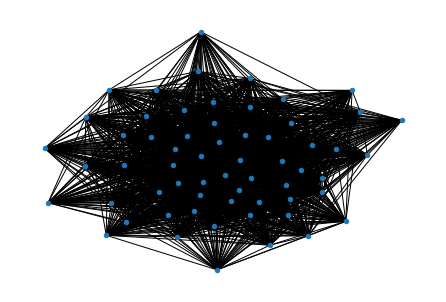

In [89]:
weights = [G2[u][v]['weight']/100 for u,v in G2.edges]
nx.draw(G2,node_size = 20, pos=nx.spring_layout(G2, weight='weight'))

In [90]:
studied_proteins = {
    'DIC1': '4932.YLR348C',
    'RGT2': '4932.YDL138W',
    'CBF5': '4932.YLR175W',
    'EST2': '4932.YLR318W'
}

proteins = set(G0.nodes)

studied_communities = {}
for key, value in studied_proteins.items():
    print(node_to_community[value])
    studied_communities[key] = tuple(result_louvain[node_to_community[value]])




4
50
45
47


In [91]:
G3 = G2.copy()
# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 0.01
edge_weights = []
for edge in G3.edges: 
    weight = G3[edge[0]][edge[1]]['weight']
    edge_weights.append(weight)
    if(weight < threshold_score):
        G3.remove_edge(edge[0],edge[1])

In [92]:
G3.remove_nodes_from(list(nx.isolates(G3)))


In [93]:
print(len(G2.edges))

1766


In [94]:
print(sorted(edge_weights)[len(edge_weights)//2])

0.09523809523809523


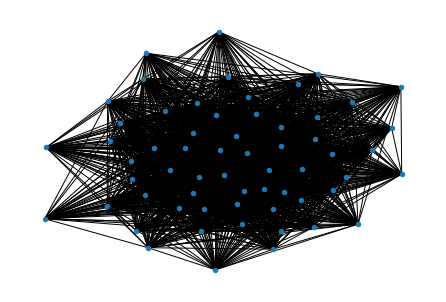

In [95]:
nx.draw(G3,node_size = 20, pos=nx.spring_layout(G2, weight='weight'))

In [96]:
import networkx.algorithms.shortest_paths as nx_path

In [97]:
class Widest_Add():
    def __init__(self, width):
        self.width = width
    def __add__(self, other):
        # maybe put a check that other has class Widest_Add. But shouldn't need.
        if isinstance(other, int):
            return Widest_Add(max(self.width, other))
        return Widest_Add(max(self.width, other.width))
    def __radd__(self, other):
        # maybe put a check that other has class Widest_Add. But shouldn't need.
        if isinstance(other, int):
            return Widest_Add(max(self.width, other))
        return Widest_Add(max(self.width, other.width)) 
    def __le__(self, other):
        if isinstance(other, int):
            other = Widest_Add(other)
        return self.width <= other.width
    def __lt__(self, other):
        if isinstance(other, int):
            other = Widest_Add(other)
        return self.width < other.width
    def __eq__(self, other):
        if isinstance(other, int):
            other = Widest_Add(other)
        return self.width == other.width
    # might need > or >= too, but I don't think so... look at _dijkstra_multisource and operations on uv_dist

def widest_weight(node1, node2, datadict):
    # This assume the graph stores a number in edge attribute 'width'
    return Widest_Add(1/datadict['weight'])

def widest_weight2(node1, node2, datadict):
    # This assume the graph stores a number in edge attribute 'width'
    return Widest_Add(datadict['weight'])



In [98]:
def get_repr_candidate(prev, curr, next):
    candidates = set(curr)

    left = set()
    for node in prev:
        left |= set(G0[node])
    right = set()
    for node in next:
        right |= set(G0[node])
    return candidates & left & right

In [99]:
def get_representative_node(prev, curr, next):
    subgraph = G0.subgraph(list(prev) + list(curr) + list(next))
    betCent = nx.betweenness_centrality(subgraph, normalized=True, endpoints=True)

    comm_nodes = [(n, betCent[n]) for n in curr]
    comm_nodes.sort(key=lambda x: x[1], reverse=True)

    reps = get_repr_candidate(prev, curr, next)
    for node, _ in comm_nodes:
        if node in reps:
            print('hit', node)
            return node

    central_node = comm_nodes[0][0]
    print('miss', central_node)
    return central_node

In [106]:
def convert_cluster_path_recursive(start, end, path):
    if len(path) == 0:
        if end in G0[start]:
            yield [end]
        return

    candidates = [n for n in path[0] if n in G0[start]]
    candidates.sort(key=lambda n: G0[start][n]['combined_score'], reverse=True)
    for node in candidates:
        for answer in convert_cluster_path_recursive(node, end, path[1:]):
            yield [node] + answer
    

            

In [107]:
def convert_cluster_path(start, end, path):
    return next(convert_cluster_path_recursive(start, end, path))

In [108]:
def try_process(start, end):
    widest_path = nx_path.dijkstra_path(G3, 
        studied_communities[start], 
        studied_communities[end], 
        widest_weight)
    widest_path2 = nx_path.dijkstra_path(G3, 
        studied_communities[start], 
        studied_communities[end], 
        widest_weight2)
    # print(len(widest_path))
    widest_path_edges = []
    for i in range(len(widest_path) - 1):
        u,v = widest_path[i], widest_path[i+1]
        widest_path_edges.append((community_to_index[u], community_to_index[v], G3[u][v]['weight']))

    # print(len(widest_path2))
    widest_path_edges2 = []
    for i in range(len(widest_path2) - 1):
        u,v = widest_path2[i], widest_path2[i+1]
        widest_path_edges2.append((community_to_index[u], community_to_index[v], G3[u][v]['weight']))
    # print(widest_path_edges)
    # print(widest_path_edges2)

    # centers = []
    # path_elems = [[studied_proteins[start]]] + widest_path + [[studied_proteins[end]]]
    # for i, community in enumerate(widest_path):
    #     c = get_representative_node(path_elems[i], community, path_elems[i+2])
    #     centers.append(c)

    centers = convert_cluster_path(studied_proteins[start], 
        widest_path, 
        studied_proteins[end]
    )

    print(centers)
    print(list(map(common_name.get, centers)))
    return start, list(map(common_name.get, centers)), end

In [119]:
def try_process_new(start, end):
    candidates = list(G3[studied_communities[start]].keys() & G3[studied_communities[end]].keys())
    candidates.sort(key=lambda c:
        G3[studied_communities[start]][c]['weight'] + G3[studied_communities[end]][c]['weight']
    )

    centers = convert_cluster_path(studied_proteins[start], 
        [
            studied_communities[start], candidates[0],
            studied_communities[end],
            [end]
        ], 
        studied_proteins[end]
    )

    print(centers)
    print(list(map(common_name.get, centers)))
    return start, list(map(common_name.get, centers)), end

In [120]:
def try_process_old(start, end):
    widest_path = nx_path.dijkstra_path(G3, 
        studied_communities[start], 
        studied_communities[end], 
        widest_weight)
    widest_path2 = nx_path.dijkstra_path(G3, 
        studied_communities[start], 
        studied_communities[end], 
        widest_weight2)
    # print(len(widest_path))
    widest_path_edges = []
    for i in range(len(widest_path) - 1):
        u,v = widest_path[i], widest_path[i+1]
        widest_path_edges.append((community_to_index[u], community_to_index[v], G3[u][v]['weight']))

    # print(len(widest_path2))
    widest_path_edges2 = []
    for i in range(len(widest_path2) - 1):
        u,v = widest_path2[i], widest_path2[i+1]
        widest_path_edges2.append((community_to_index[u], community_to_index[v], G3[u][v]['weight']))
    # print(widest_path_edges)
    # print(widest_path_edges2)

    centers = []
    path_elems = [[studied_proteins[start]]] + widest_path + [[studied_proteins[end]]]
    for i, community in enumerate(widest_path):
        c = get_representative_node(path_elems[i], community, path_elems[i+2])
        centers.append(c)


    print(centers)
    print(list(map(common_name.get, centers)))
    return start, list(map(common_name.get, centers)), end

In [121]:
for start in ['DIC1', 'RGT2']:
    for end in ['CBF5', 'EST2']:
        _, path, _ = try_process_new(start, end)
        print(start, *path, end, sep='\n')

StopIteration: 

In [ ]:
print(*try_process('RGT2', 'EST2'))

StopIteration: 

In [ ]:
def find_paths(source, target, limit=4):
    if limit == 0:
        if source == target:
            yield []
        return

    for node in G3[source]:
        for path in find_paths(node, target, limit-1):
            yield [source] + path

In [ ]:
def path_weight(path):
    w = 0
    for i in range(len(path)-1):
        w += G3[path[i]][path[i+1]]['weight']
    return w

In [ ]:
len(G3.nodes)

27

In [ ]:
close_paths = sorted(
    list(find_paths(studied_communities['RGT2'], studied_communities['EST2'])), 
    key=path_weight, 
reverse=True)

In [ ]:
candidate = close_paths[0]

In [ ]:
def get_reps_path(start, end, path, curr_index=0):
    curr = s

    